In [1]:
import numpy as np
from RadarDevKit import RadarModule
from RadarDevKit.ConfigClasses import SysParams
from config import RunParams, get_radar_module, get_radar_params, get_run_params

radar_module = get_radar_module()
run_params= get_run_params()
radar_params = get_radar_params()
num_time_steps = 250

Connect
GetHwParams
Number of the connected Radar Module:  2130000071
GetSysParams
SetSysParams
GetSysParams
Frequency [MHz]:  24000
Bandwidth [MHz]:  600
Ramp-time [ms]:  7
Number Points:  512
Bin Size (Resolution) [m]:  0.249887

Connected to the radar.


In [2]:

from collect_data import get_range_bins
from get_all_sensor_data import get_fd_data_with_angles_from_radar

data_fd = []
angle_data = []
range_axis = get_range_bins(radar_module)

for i in range(num_time_steps):
    data_ret = get_fd_data_with_angles_from_radar(run_params, radar_module, radar_params)
    # print(f"Data Shape: {data_ret.shape}")
    selected_columns = data_ret[:4]
    # print(f"Selected Colums 1: {selected_columns.shape}")
    angle_columns = data_ret[:-4] # All angle colums
    print(f"Angles Colums 1: {angle_columns.shape}")
    angles_columns = angle_columns[:1] # We only really need the first two...
    # print(f"Angles Colums 2: {angles_columns.shape}")
    # averages_angles = np.mean(angles_columns, axis=0)
    # print(f"Angles Shape: {averages_angles.shape}")
    # print(selected_columns.T.shape)
    print(f"Angle col: {angles_columns.reshape(-1).shape}")
    data_fd.append(selected_columns)
    # print(averages_angles.shape)
    # print(averages_angles)
    angle_data.append(angles_columns.reshape(-1))
    

Angles Colums 1: (4, 512)
Angle col: (512,)
Angles Colums 1: (4, 512)
Angle col: (512,)
Angles Colums 1: (4, 512)
Angle col: (512,)
Angles Colums 1: (4, 512)
Angle col: (512,)
Angles Colums 1: (4, 512)
Angle col: (512,)
Angles Colums 1: (4, 512)
Angle col: (512,)
Angles Colums 1: (4, 512)
Angle col: (512,)
Angles Colums 1: (4, 512)
Angle col: (512,)
Angles Colums 1: (4, 512)
Angle col: (512,)
Angles Colums 1: (4, 512)
Angle col: (512,)
Angles Colums 1: (4, 512)
Angle col: (512,)
Angles Colums 1: (4, 512)
Angle col: (512,)
Angles Colums 1: (4, 512)
Angle col: (512,)
Angles Colums 1: (4, 512)
Angle col: (512,)
Angles Colums 1: (4, 512)
Angle col: (512,)
Angles Colums 1: (4, 512)
Angle col: (512,)
Angles Colums 1: (4, 512)
Angle col: (512,)
Angles Colums 1: (4, 512)
Angle col: (512,)
Angles Colums 1: (4, 512)
Angle col: (512,)
Angles Colums 1: (4, 512)
Angle col: (512,)
Angles Colums 1: (4, 512)
Angle col: (512,)
Angles Colums 1: (4, 512)
Angle col: (512,)
Angles Colums 1: (4, 512)
Angle 

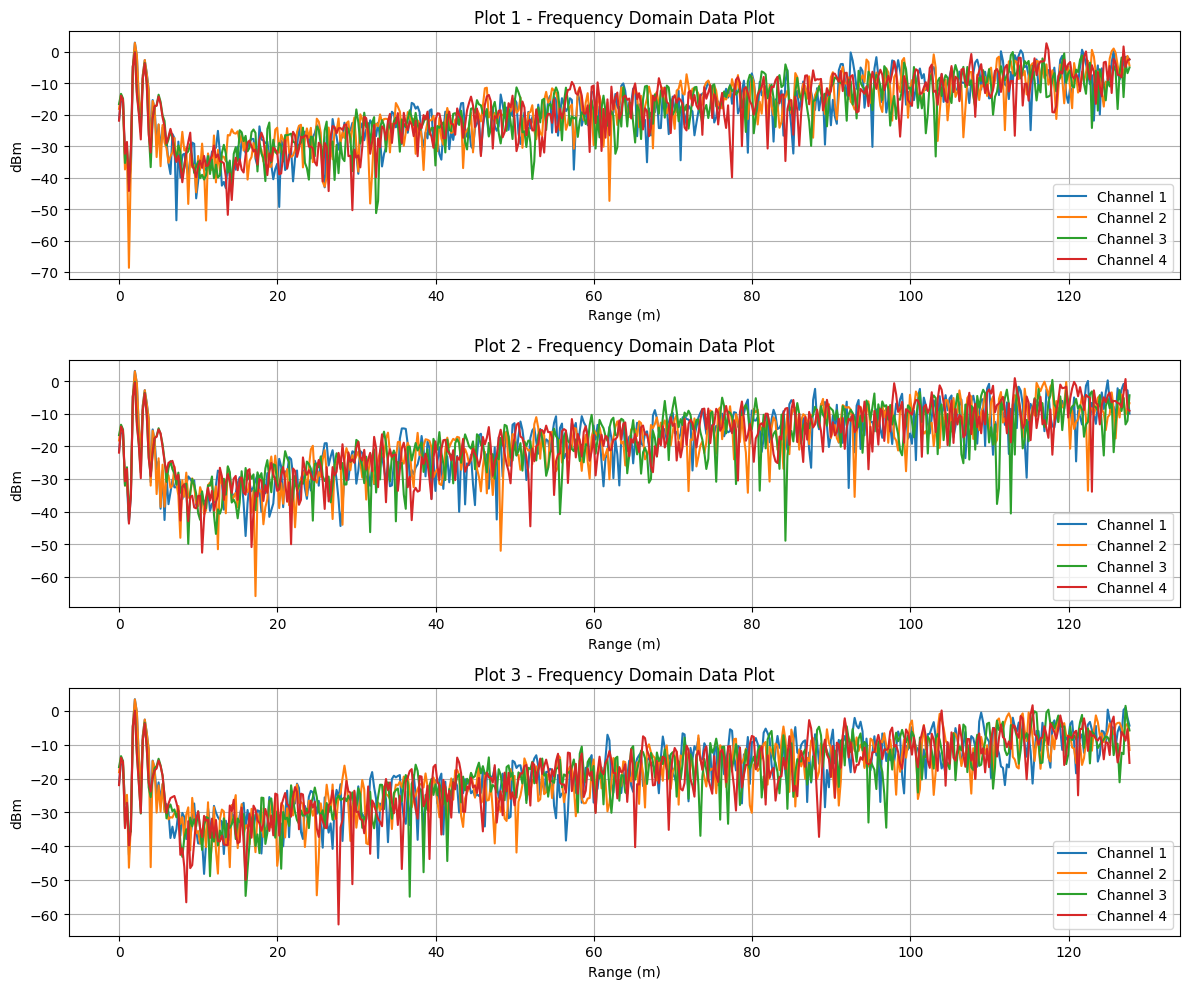

In [3]:
import matplotlib.pyplot as plt

# Assuming `test` is already populated with your data
# Create a single figure for all subplots
plt.figure(figsize=(12, 10))  # Adjust the figure size to accommodate all subplots

# Iterate over the first three arrays
for i, data in enumerate(data_fd):
    # print(data.shape)
    if (i > 2):
        continue
    ax = plt.subplot(3, 1, i + 1)  # Create a subplot for each array
    for ch in range(4):
        ax.plot(range_axis, data[ch, :], label=f'Channel {ch+1}')  # Ensure correct indexing

    ax.set_title(f'Plot {i+1} - Frequency Domain Data Plot')
    ax.set_xlabel('Range (m)')
    ax.set_ylabel('dBm')
    ax.legend()
    ax.grid(True)

# Adjust layout to prevent overlap
plt.tight_layout()
plt.show()

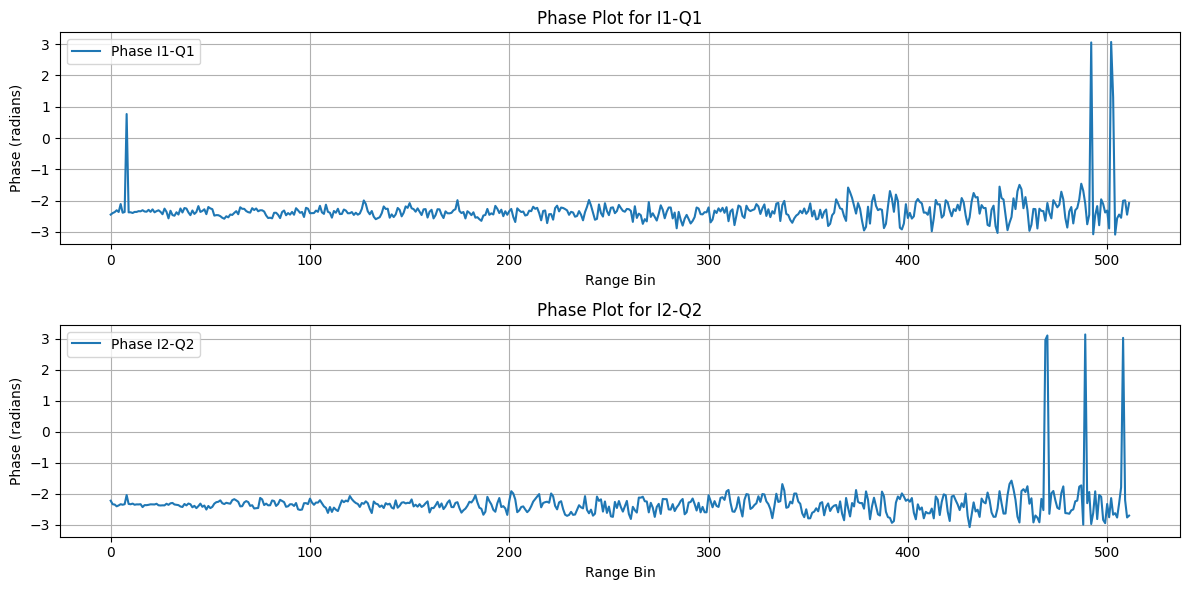

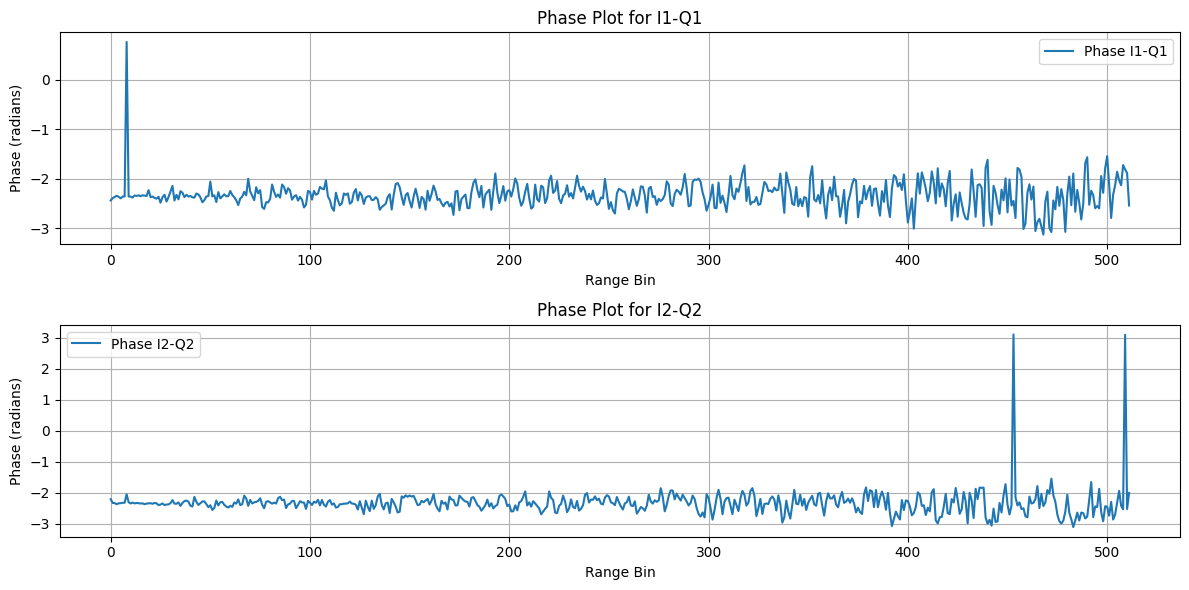

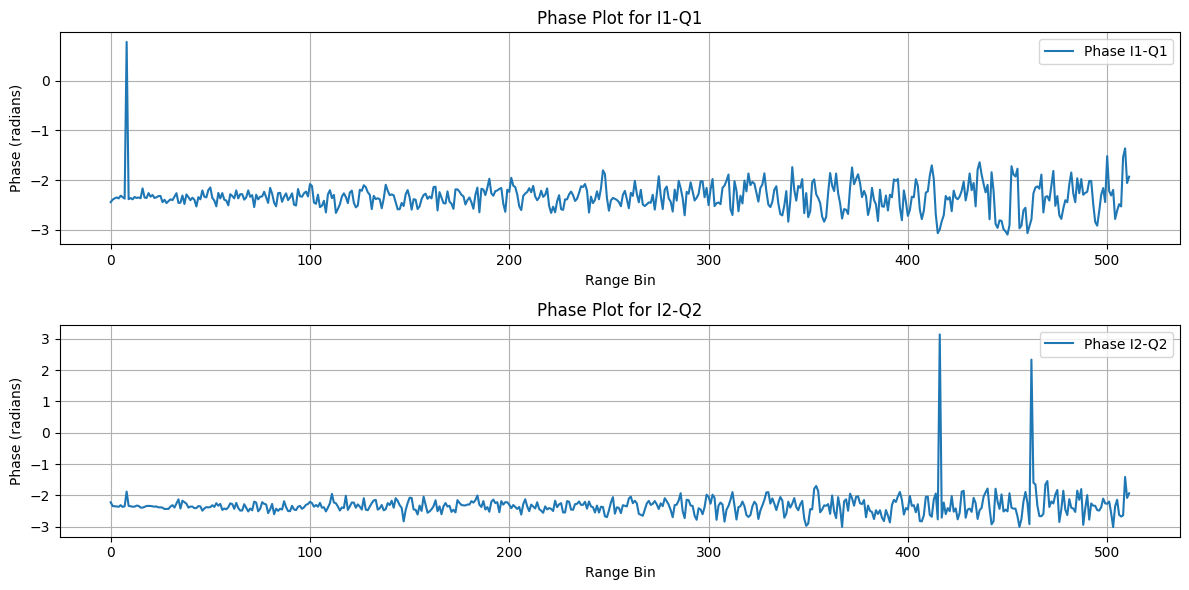

In [4]:
import matplotlib.pyplot as plt

radial_velocity_list = []

# Radial velocity
for i, data in enumerate(data_fd):
    if i > 2:
        continue
    I1 = data[0]
    Q1 = data[1]
    I2 = data[2]
    Q2 = data[3]
    
    complex_signal_1 = I1 + 1j * Q1
    complex_signal_2 = I2 + 1j * Q2
    
    phase_1 = np.angle(complex_signal_1)
    phase_2 = np.angle(complex_signal_2)
    # Apply phase unwrapping
    phase_1_unwrapped = np.unwrap(phase_1)
    phase_2_unwrapped = np.unwrap(phase_2)
    
    phase_difference = phase_1_unwrapped - phase_2_unwrapped
    
    # Plotting the phase
    plt.figure(figsize=(12, 6))

    plt.subplot(2, 1, 1)
    plt.plot(phase_1, label='Phase I1-Q1')
    plt.xlabel('Range Bin')
    plt.ylabel('Phase (radians)')
    plt.title('Phase Plot for I1-Q1')
    plt.grid(True)
    plt.legend()

    plt.subplot(2, 1, 2)
    plt.plot(phase_2, label='Phase I2-Q2')
    plt.xlabel('Range Bin')
    plt.ylabel('Phase (radians)')
    plt.title('Phase Plot for I2-Q2')
    plt.grid(True)
    plt.legend()

    plt.tight_layout()
    plt.show()

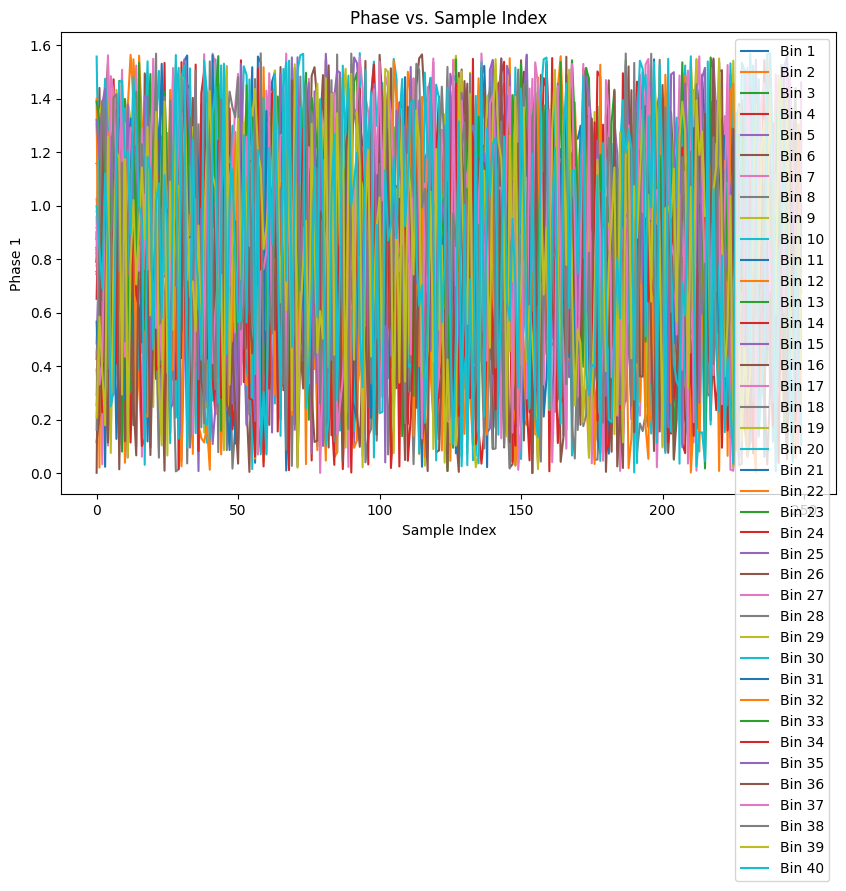

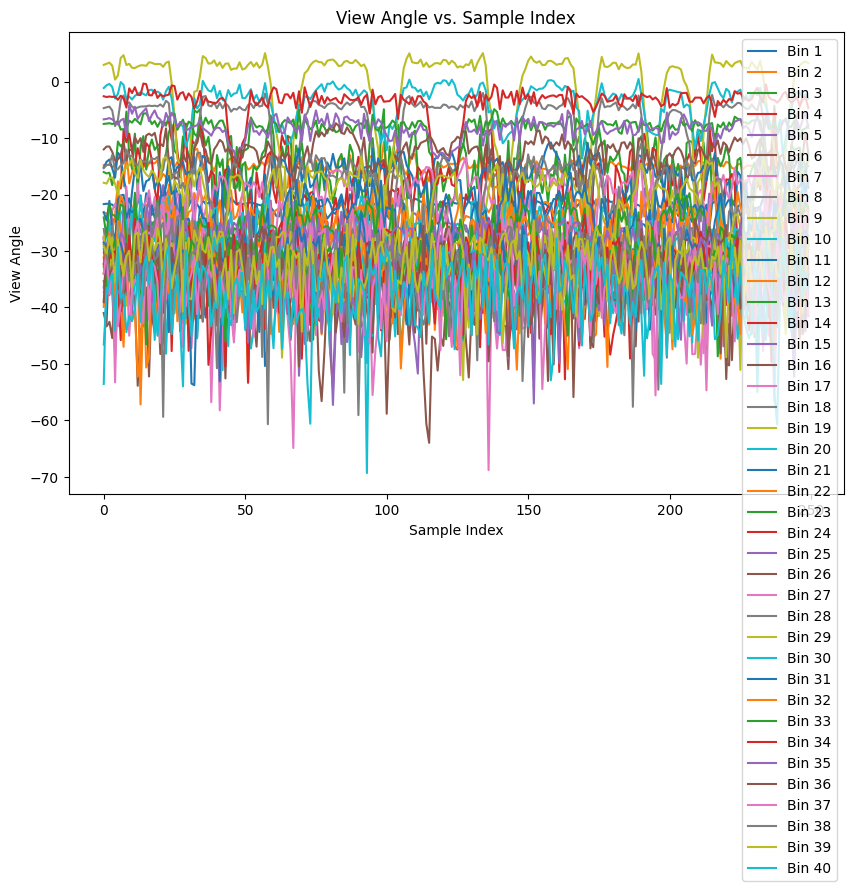

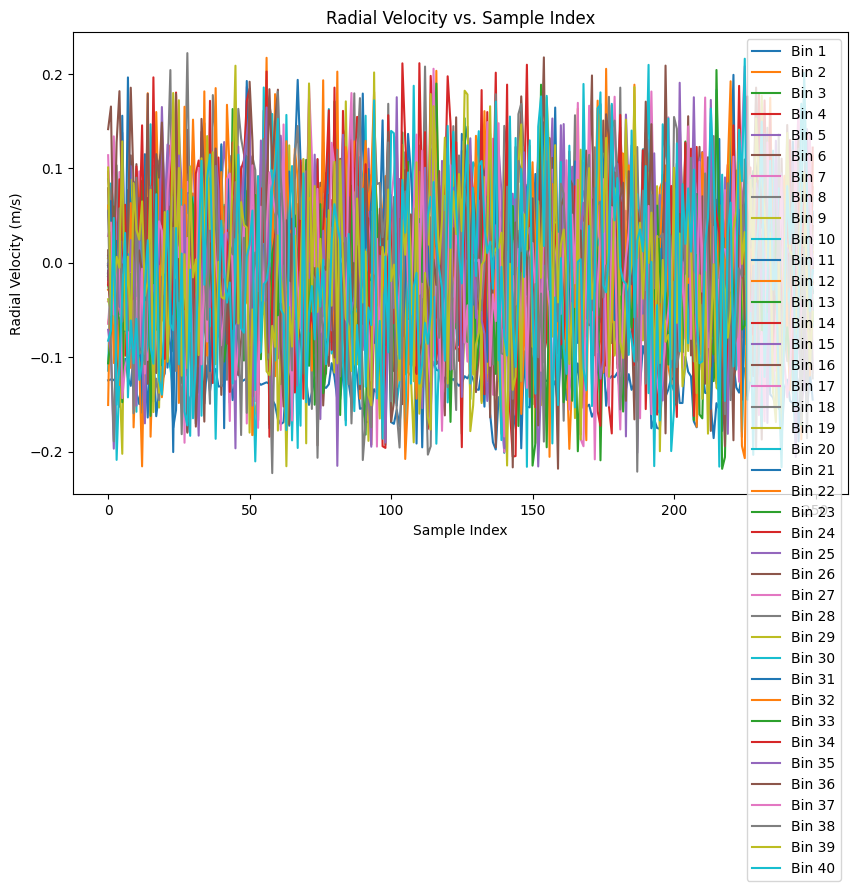

In [5]:

from constants import DIST_BETWEEN_ANTENNAS, SPEED_LIGHT
import numpy as np
import matplotlib.pyplot as plt

# Assuming data_fd is your data array of shape (N, 4, 512)
# Sample data for demonstration (replace with your actual data)
# data_fd = np.random.randn(N, 4, 512)

# Constants
wavelength = 0.01238  # in meters (for 24.3 GHz)
time_interval = 0.007*0.98304  # in seconds
fc = (radar_params.minFreq*(10**6)) + (radar_params.manualBW / 2)*(10**6) # Central frequency in Hz - Conversion from Mhz to Hz

max_bin = 40
# Initialize a list to hold radial velocity data
radial_velocity_list = []
phase1_list = []
phase2_list = []
view_angle_deg = []

# Function to convert dBm to linear scale (Watts)
def dbm_to_linear(dbm):
    return 10**(dbm / 10) / 1000  # Convert from dBm to Watts

for i, data in enumerate(data_fd):
    I1_dbm = data[0]
    Q1_dbm = data[1]
    I2_dbm = data[2]
    Q2_dbm = data[3]
    
    # Convert dBm to linear scale
    I1 = dbm_to_linear(I1_dbm)
    Q1 = dbm_to_linear(Q1_dbm)
    I2 = dbm_to_linear(I2_dbm)
    Q2 = dbm_to_linear(Q2_dbm)
    
    complex_signal_1 = I1 + 1j * Q1
    complex_signal_2 = I2 + 1j * Q2
    
    phase_1 = np.angle(complex_signal_1)
    phase1_list.append(phase_1[0:max_bin])
    
    phase_2 = np.angle(complex_signal_2)
    phase2_list.append(phase_2[0:max_bin])
    phase_difference = np.unwrap([phase_1, phase_2], axis=0)[1] - np.unwrap([phase_1, phase_2], axis=0)[0]
    
    # Ensure the phase difference is within -pi to pi
    phase_difference = np.arctan2(np.sin(phase_difference), np.cos(phase_difference))
    
    radial_velocity = (phase_difference * wavelength) / (4 * np.pi * time_interval)
    radial_velocity_list.append(radial_velocity[0:max_bin])
    view_angle_deg.append(angle_data[i][0:max_bin])

# Convert to numpy array for easier plotting
radial_velocity_array = np.array(radial_velocity_list)
view_angle_deg = np.array(view_angle_deg)
phase1_list = np.array(phase1_list)

plt.figure(figsize=(10, 6))
for i in range(max_bin):
    plt.plot(phase1_list[:, i], label=f'Bin {i+1}')
plt.xlabel('Sample Index')
plt.ylabel('Phase 1')
plt.title('Phase vs. Sample Index')
plt.legend()
plt.show()

plt.figure(figsize=(10, 6))
for i in range(max_bin):
    plt.plot(view_angle_deg[:, i], label=f'Bin {i+1}')
plt.xlabel('Sample Index')
plt.ylabel('View Angle')
plt.title('View Angle vs. Sample Index')
plt.legend()
plt.show()

plt.figure(figsize=(10, 6))
for i in range(max_bin):
    plt.plot(radial_velocity_array[:, i], label=f'Bin {i+1}')
plt.xlabel('Sample Index')
plt.ylabel('Radial Velocity (m/s)')
plt.title('Radial Velocity vs. Sample Index')
plt.legend()
plt.show()


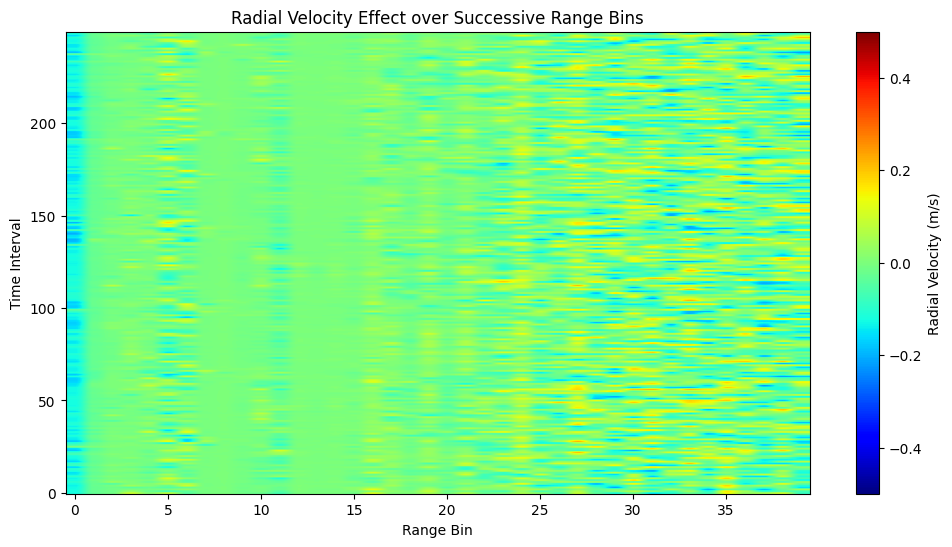

In [8]:
# Plotting
plt.figure(figsize=(12, 6))
plt.imshow(radial_velocity_array, aspect='auto', cmap='jet', origin='lower', vmin=-0.5, vmax=0.5)
plt.colorbar(label='Radial Velocity (m/s)')
plt.ylabel('Time Interval')
plt.xlabel('Range Bin')
plt.title('Radial Velocity Effect over Successive Range Bins')
plt.show()

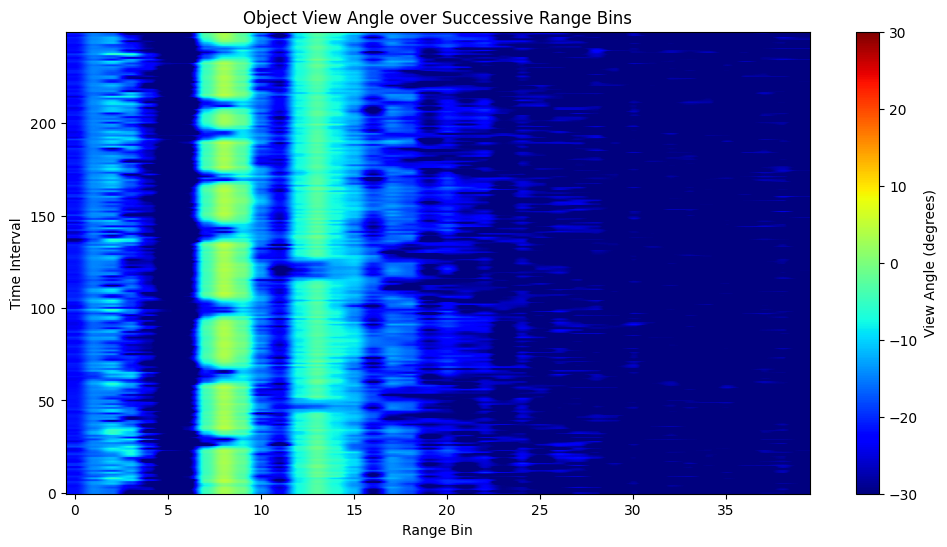

In [7]:


plt.figure(figsize=(12, 6))
im = plt.imshow(view_angle_deg, aspect='auto', cmap='jet', origin='lower', vmin=-30, vmax=30)
plt.colorbar(im, label='View Angle (degrees)')
plt.ylabel('Time Interval')
plt.xlabel('Range Bin')
plt.title('Object View Angle over Successive Range Bins')
plt.show()